# Marketing Analysis of Car Sales



In [3]:
!pip install pandas
!pip install jupysql
!pip install matplotlib
!pip install click

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%%capture

ad_channel_path="ad_channels.csv"
clicks_path="clicks.csv"
locks_path="locks.csv"
sales_path="sales.csv"
spend_path="spend.csv"
vehicle_path="vehicles.csv"

ad_channels=pd.read_csv(ad_channel_path)
clicks=pd.read_csv(clicks_path)
locks=pd.read_csv(locks_path)
sales=pd.read_csv(sales_path)
spend=pd.read_csv(spend_path)
vehicles=pd.read_csv(vehicle_path)

%load_ext sql
%sql sqlite://

%sql --persist ad_channels
%sql --persist clicks
%sql --persist locks
%sql --persist sales
%sql --persist spend
%sql --persist vehicles

# What category of channel has the lowest cost per click? Why do you think this channel has the lowest CPC?

The Search Engine category has the lowest cost-per-click (CPC) at $1.26 per click. This is because users are actively searching for information, resulting in higher intent and more efficient matching between ads and audience needs. Additionally, search advertising benefits from mature optimization tools, broad audience reach, and lower competition per impression compared to niche categories, helping to keep costs down.



In [5]:
def prepare_channels(ad_channels):
    """
    Note: For the ad channels, the channel_name is in the format of category-partner_campaign.
    Purpose: Parse the category string from the partner_campaign to later group together results by categories
    Input: Takes in the channels dataframe.
    Output: Dataframe of channel_id and category name
    Example: "Search Engine-Hooli_Convertible" now becomes "Search Engine" and "Hooli_Convertible".
    """
    channels = ad_channels.copy()
    channels[['category', 'partner_campaign']] = channels['channel'].str.split('-', n=1, expand=True)
     # Split the string at most once at the first occurrence of the hyphen '-'
    return channels

def compute_total_spend(spend):
    """
    Purpose: To sum the spend by channel_id
    Input: Takes in the spend dataframe.
    Output: Dataframe of total spend by channel_id
    """
    return spend.groupby('channel_id')['spend'].sum()

def compute_total_clicks(clicks):
    """
    Purpose: To count the number of clicks by channel_id
    Input: Takes in the clicks dataframe.
    Ouput: Dataframe of total clicks by user_id if user_id is NOT Null
    """
    return clicks.groupby('channel_id')['user_id'].count().reset_index(name='click_count')

def merge_data(channels, total_spend_by_channel_id, total_clicks_by_channel_id):
    """
    Purpose: To merge the channels_df, spend_df, and clicks_df together on channel_id
    Input: The channels_df, spend_df, and clicks_df dataframes
    Output: Summary Dataframe that contains the channel_id,category, click_count, and spend_count
    """
    channels = channels.merge(total_clicks_by_channel_id, on='channel_id', how='left')
    channels = channels.merge(total_spend_by_channel_id, on='channel_id', how='left')
    return channels

def calculate_cpc_summary(channels):
    """
    Purpose: Calculates the final cost per click (CPC)
    Input: the channels and spend dataframes
    Output: The CPC by category
    """
    CPC = channels.groupby('category')[['spend', 'click_count']].sum().reset_index()
    CPC['CPC'] = CPC['spend'] / CPC['click_count']
    return CPC[['category', 'CPC']]


# The Cost-per-click by category
channels = prepare_channels(ad_channels)
total_spend_by_channel_id = compute_total_spend(spend)
total_clicks_by_channel_id = compute_total_clicks(clicks)
channels = merge_data(channels, total_spend_by_channel_id, total_clicks_by_channel_id)
final_cpc = calculate_cpc_summary(channels)

final_cpc


,category,CPC
0,Finance Partnership,3.207268
1,Online Video,2.137102
2,Search Engine,1.258049
3,Social Media,1.315962
4,Third Party Listing,2.971666


The **goal** was to calculate the cost-per-click (CPC), which is defined as Total Spend / Total Num Clicks by category.

Just a quick note, I did it in Python first and then SQL.

1. First thing I wanted to do was to segment the category from the ads_channel, which is in the format category-Partnership_Campaign. Seeing that is the standard format for all entries, I can just split the string by '-' and keep everything before '-' which is category and then everything after as partnship_campaign. Then later able to group by category. I did not want to do that now, since I still have to calculate the total spend and clicks by channel_id, which returns a dataframe called channels.

2. Next, I wanted to calculate the total spend by channel. So I just sum spend by channel id

3. Next, I proceeded similarly with the clicks but used count over user_id since each row entry has a user_id (that is NOT NULL) provides a single a click.

4. Next, I merge the channels dataframe and the resulting clicks and spend dataframes together on channel_id. So I get a final dataframe that has channel_id, category, spend, and clicks.

5. Finally, I just need to calculate CPC defined as Total Spend/ Total Clicks.


Using the above process, I validated the python code in SQL.

In [8]:
%%sql

WITH spend_clicks AS (
        SELECT
            c.channel_id,
            c.click_count,
            s.total_spend
        FROM
        (SELECT channel_id, COUNT(user_id) AS click_count
         FROM clicks
         GROUP BY channel_id) c
        JOIN
        (SELECT channel_id, SUM(spend) AS total_spend
         FROM spend
             GROUP BY channel_id) s
            ON c.channel_id = s.channel_id
),

channel_info AS (
  SELECT
    channel_id,
    SUBSTR(channel, 1, INSTR(channel, '-') - 1) AS category
      -- SUBSTR(string, start_position, length)
    -- Extracts a substring starting from position 1 (first character),
      -- and goes up to just before the hyphen (-)
    --INSTR(channel, '-') Finds the position of the first'-' in the string e.g. 7

     -- the -1 is to exclude the hypher ('-') itself from the result

  FROM ad_channels
),

joined_data AS (
  SELECT
    sc.channel_id,
    ci.category,
    sc.total_spend,
    sc.click_count
  FROM spend_clicks sc
  JOIN channel_info ci ON sc.channel_id = ci.channel_id
)

SELECT
  category,
  ROUND(SUM(total_spend) * 1.0 / SUM(click_count), 4) AS CPC
  -- Sum over the total clicks and spend by catergory
FROM joined_data
GROUP BY category
ORDER BY CPC ASC;


Running query in 'sqlite://'

category,CPC
Search Engine,1.258
Social Media,1.316
Online Video,2.1371
Third Party Listing,2.9717
Finance Partnership,3.2073


 # What are the top three campaigns in terms of number of sales generated by first touch attribution?

The top 3 campaigns in terms of number of sales were Sedan (266 sales), Convertible (188), and 25+ (176).

In [ ]:
def fill_missing_users_in_sales(sales, locks):
    """
    Purpose: During EDA, there were missing 'user_id' in sales. We use 'user_id' for merging, so we need to fill these values in using lock.
    Recall that not every lock turns into a sale, but every sale must be preceded by a lock. Use 'lock_id' to get 'user_id'from locks table to fill in missing 'user_id' in sales.
    Input: sales and locks dataframes
    Output: sales table with filled in missing 'user_id'
    """

    sales['user_id'] = sales['user_id'].combine_first(
        sales['lock_id'].map(locks.set_index('lock_id')['user_id'])
        ) # takes the 'lock_id' to 'user_id' from locks table and maps the 'user_id' to the NaN 'user_id' in the sales table

    # locks.set_index('lock_id')['user_id']
    ## This turns the locks DataFrame into a Series that maps lock_id → user_id

   # sales['lock_id'].map(...)
     ## Takes the lock_id from each row in sales and looks up the corresponding user_id using the mapping from locks

   # combine_first(...)
     ## Combines two Series: the existing sales['user_id'] and the mapped user_ids from lock_id

    # Combines the existing sales['user_id'] column with the result.
      ## If a user_id is already present, it keeps it.
    return sales


def first_touch(clicks):
    """
    Purpose: To calculate the first touch attribution
    Input: clicks table
    Output: dataframe containing each user's earliest recorded click, with one row pe
    """
    clicks['click_datetime'] = pd.to_datetime(clicks['click_datetime']) # converts click_datetime to datetime format for consistent handling
    first_touch = clicks.sort_values(by = 'click_datetime').drop_duplicates(subset = 'user_id', keep = 'first') # sorts all clicks by time and keeps only the first click per user to identify each user's first interaction with the site
    return first_touch


def extract_parts(channel):
    """
    Purpose: To consider the cases when some channels have separate campaigns within them and some don't. Treat the partnership as its own campaign if it doesn't have one.  e.g. Finance Partnership-Debit Dharma
    Input: ad_channels dataframe
    Output: the category, partnership, and campaign are parsed from channel string
    """
    # Recall it is in format of category-partnership_campaign
    category = channel.split('-')[0] # gets the first part of the string
    if '_' in channel:
        partnership = channel.split('-')[1].split('_')[0]
        # channel.split('-')[1]
           ## "Search-Hooli_Convertible" → ["Search", "Hooli_Convertible"]
        # .split('_')[0]
          ## [ ]"Hooli_Convertible"] --> ["Hooli", "Convertible"]
        campaign = channel.split('_')[1]

    else:
        partnership = channel.split('-')[1]
        campaign = partnership

    return category, partnership, campaign

def parsing_channels(ad_channels, extract_parts):
    """
    Purpose: The channel in ad_channels are in the format of category-partnership_campaign. We want to parse this for easier handling.
    Input: ad_channels dataframe, extract_parts function
    Output: parsed_channels dataframe that has columns category, partnership, and campaign
    """
    parsed_channels = ad_channels.copy()
    parsed_channels[['category', 'partnership', 'campaign']] = parsed_channels['channel'].apply(lambda x : pd.Series(extract_parts(x))) # applies the extract_parts function
    return parsed_channels

def merging_metrics(first_touch, sales, parsed_channels):
    """
    Purpose: Merging the first_touch dataframe that has clicks data, the sales dataframe, and the parsed_channels dataframe
    Input: first_touch, sales, and parsed_channels dataframes
    Output: merged DataFrame containing user click data, sales data, and parsed channel campaign data
    """
    first_touch_channels_parsed = first_touch.merge(parsed_channels[['channel_id','campaign']], on = 'channel_id', how = 'left')
    first_touch_channels_parsed = sales.merge(first_touch_channels_parsed, on = 'user_id', how = 'left')
    return first_touch_channels_parsed

def campaign_counts(joined_data):
    """
    Purpose: Returns the final dataframe of the top 3 campaigns by number of sales
    Input: The joined dataframe from merging_metrics
    Output: Top 3 campaigns by number of sales
    """
    campaign_counts = joined_data.groupby('campaign')['sale_id'].count().reset_index(name = 'sale_count').sort_values('sale_count', ascending = False)

    campaign_counts.columns = ['campaign', 'sale_count']
    return campaign_counts



sales = fill_missing_users_in_sales(sales, locks)

first = first_touch(clicks)

parsed = parsing_channels(ad_channels, extract_parts)

joined = merging_metrics(first, sales, parsed)

counts = campaign_counts(joined)

counts

,campaign,sale_count
8,Sedan,266
1,Convertible,188
0,25+,176
10,Truck,152
2,Debit Dharma,140
3,Giving Vine,109
4,HeadLedger,99
7,RealTruck,67
6,ManualBarter,63
5,KnickKnack,47


The **goal** was to figure out which top 3 campaigns have the most number of sales.

Before diving into the code, there were some really interesting things in the data.

- First, we had to apply the first touch attribution, which means that the first click the user has with the company. I had to read and think more deeply on how to do that. For example, does a click on social-media then later on a click on search-engine, which results in a lock. How do we define first attribution by either what causes the lock or when the customer first interacts with the company.

Once I figured it was the latter, then it was simply sorting the dataframe by click_datetime and then by user_id. We just want to keep the first entry.

- Second, my plan was to join the first_click with the sales data on user_id. However, after checking if there were any Nulls, I saw that they exist in the sales dataframe (need to figure out why in the data pipeline). Anyway, looking back, I know that a user has to lock-in the vehicle first, and then that may be converted to a sale. The user_id would flow through. Seeing that there are no NULLS for user_id in locks, it is logical to fill in any NULL user_values in the sales from the locks. That is what I did.

- Lastly, we wanted campaigns and the ad_channels were in the 'category-partnership_campaign' format but also, the condition where the partnership is the campaign if there is no declarative 'campaign'. So, I did a similar process before of splitting the channel string with 'category' and 'partnership_campaign'. Then splitting that string based on '_'. However, I had to create an if statement if there is an '_' in the string.


After doing all of that, I was able to just merge the everything on 'user_id' and 'channel_id' to get counts using a group by campaign.

In [9]:
%%sql

WITH FirstTouch AS ( -- Calculate the first touch attribution
    SELECT user_id,
           MIN(click_datetime) AS first_click_time,
           channel_id
    FROM clicks
    GROUP BY user_id   -- by user_id
),

ChannelsParsed AS ( -- Parsing the channel into category, partnership, and campaign
    SELECT
        channel_id,
        SUBSTR(channel, 1, INSTR(channel, '-') - 1) AS category,
                      -- SUBSTR(string, start_position, length)
    -- Extracts a substring starting from position 1 (first character),
      -- and goes up to just before the hyphen (-)
    --INSTR(channel, '-') Finds the position of the first'-' in the string e.g. 7
    --INSTR(string, substring)

     -- the -1 is to exclude the hypher ('-') itself from the result
        CASE
            WHEN INSTR(channel, '_') > 0 THEN
            -- INSTR(string, substring)
            -- Returns the position (1-based index) of the first underscore in string
            -- If '_' NOT found, then returns a 0
                SUBSTR(channel, INSTR(channel, '-') + 1, INSTR(channel, '_') - INSTR(channel, '-') - 1)
            -- If there is a partnership, then we use that
            -- The indexing between the '-' and the '_'
            ELSE
                SUBSTR(channel, INSTR(channel, '-') + 1)
            -- If there is no '_', then we grab everything after the '-'
        END AS partnership,

        CASE
            WHEN INSTR(channel, '_') > 0 THEN
            -- if there is a '_', then we grab everthing after '_'
                SUBSTR(channel, INSTR(channel, '_') + 1)
            ELSE
            -- if there is NO '_', then we grab everything after '-'
                SUBSTR(channel, INSTR(channel, '-') + 1)
        END AS campaign
    FROM ad_channels
),

SalesCount AS ( --During EDA, there are user_id that are NULL in sales, so we cross-reference with the locks
    SELECT
        COALESCE(s.user_id, l.user_id) AS user_id, -- Fills in s.user_id as Null with l.user_id
        s.sale_datetime,
        s.sale_id
    FROM sales s
    INNER JOIN locks l ON s.lock_id = l.lock_id
)

SELECT ads.campaign, COUNT(sc.sale_id) AS num_sales  -- Number of sales per campaign
FROM ChannelsParsed ads
JOIN FirstTouch ftc ON ads.channel_id = ftc.channel_id
INNER JOIN SalesCount sc ON sc.user_id = ftc.user_id  -- Only include users who have sales
GROUP BY ads.campaign
ORDER BY num_sales DESC
LIMIT 3;


Running query in 'sqlite://'

campaign,num_sales
Sedan,266
Convertible,188
25+,176


# Which campaigns had the most month over month growth/decline in number of sales generated from Oct to Dec?

From October to November, all campaigns had negative sales. The most in decline was the Sedan with 62 fewer number of sales, followed by the convertible with 48 fewer sales. The least in decline was the ManuelBarter at 11 fewer sales.

Now, from November to December, the campaigns with the most growth in sales were the 25+ and RealTruck campaigns with 18 more sales. The only campaign with a decline in sales was the KnickKnack at 1 fewer sale.

In [15]:
def convert_datetime(clicks):
    """
    Purpose: Convert the 'click_datetime' column to datetime format in the clicks dataframe.
    Input: clicks dataframe
    Output: clicks dataframe with 'click_datetime' as datetime
    """
    clicks['click_datetime'] = pd.to_datetime(clicks['click_datetime'])
    return clicks

def get_first_touch(clicks):
    """
    Purpose: Sort the clicks dataframe by 'click_datetime' and drop duplicates for each 'user_id', keeping the first occurrence.
    Input: clicks dataframe
    Output: dataframe with first touch per 'user_id'
    """
    first_touch = clicks.sort_values('click_datetime').drop_duplicates('user_id', keep='first')
    return first_touch

def fill_missing_users_in_sales(sales, locks):
    """
    Purpose: Fill missing 'user_id' in sales using 'lock_id' from the locks dataframe.
    Input: sales dataframe, locks dataframe
    Output: sales dataframe with filled 'user_id' column
    """
    sales['user_id'] = sales['user_id'].combine_first(
        sales['lock_id'].map(locks.set_index('lock_id')['user_id'])
    )
    return sales

def merge_sales_with_channel(sales, first_touch):
    """
    Purpose: Merge sales with the first touch information (channel_id).
    Input: sales dataframe, first_touch dataframe
    Output: sales dataframe with added 'channel_id'
    """
    sales_with_channel = pd.merge(sales, first_touch[['user_id', 'channel_id']], on='user_id', how='left')
    return sales_with_channel

def extract_parts(channel):
    """
    Purpose: Parse the channel into category, partnership, and campaign parts.
    Input: channel string
    Output: tuple (category, partnership, campaign)
    """
    category = channel.split('-')[0]

    if '_' in channel:
        partnership = channel.split('-')[1].split('_')[0]
        campaign = channel.split('_')[1]
    else:
        partnership = channel.split('-')[1]
        campaign = partnership

    return category, partnership, campaign

def parse_channels(ad_channels):
    """
    Purpose: Apply 'extract_parts' to the 'channel' column in ad_channels dataframe to parse the categories.
    Input: ad_channels dataframe
    Output: dataframe with 'category', 'partnership', 'campaign' columns
    """
    parsed_channels = ad_channels.copy()
    parsed_channels[['category', 'partnership', 'campaign']] = parsed_channels['channel'].apply(
        lambda x: pd.Series(extract_parts(x))
    )
    return parsed_channels

def filter_sales_by_date(sales_with_channel, start_date, end_date):
    """
    Purpose: Filter sales within the specified date range.
    Input: sales_with_channel dataframe, start_date, end_date
    Output: filtered sales dataframe
    """
    sales_with_channel['sale_datetime'] = pd.to_datetime(sales_with_channel['sale_datetime'])
    filtered_sales = sales_with_channel[
        (sales_with_channel['sale_datetime'] >= start_date) &
        (sales_with_channel['sale_datetime'] <= end_date)
    ]
    return filtered_sales

def generate_sales_per_month(filtered_sales):
    """
    Purpose: Generate a count of sales per month and campaign.
    Input: filtered_sales dataframe
    Output: sales_per_month dataframe
    """
    filtered_sales['sale_month'] = filtered_sales['sale_datetime'].dt.to_period('M') # Created a column called sale_month
    sales_per_month = filtered_sales.groupby(['sale_month', 'campaign']).size().reset_index(name='num_sales')
    # when you want to count the total number of rows in each group, regardless of whether any specific columns have missing values.
    return sales_per_month

def create_sales_pivot(sales_per_month):
    """
    Purpose: Create a pivot table for sales per month and campaign.
    Input: sales_per_month dataframe
    Output: sales pivot table
    """
    sales_per_month_pivot = sales_per_month.pivot(index='campaign', columns='sale_month', values='num_sales').fillna(0)
    # creating a pivot table for easier readability and handling
     # wnated to create an index by campaign
    return sales_per_month_pivot

def calculate_growth(sales_per_month_new):
    """
    Purpose: Calculate month-to-month sales growth/decline.
    Input: sales_per_month_new pivot table
    Output: updated sales_per_month_new with growth/decline columns
    """
    sales_per_month_new['OCT_NOV'] = sales_per_month_new[pd.Period('2022-11')] - sales_per_month_new[pd.Period('2022-10')]
    sales_per_month_new['NOV_DEC'] = sales_per_month_new[pd.Period('2022-12')] - sales_per_month_new[pd.Period('2022-11')]

    return sales_per_month_new


def most_growth_decline(sales_per_month_new):
    """
    Purpose: To return the campaigns with the most month-over-month growth/decline from Oct to Dec 20222
    Input: sales_per_month_new dataframe
    Output: dataframes of most_growth_nov, most_growth_dec, most_decline_nov, most_decline_dec
    """
    # Growth
    most_growth_nov = sales_per_month_new['OCT_NOV'].sort_values(ascending = False)
    most_growth_dec = sales_per_month_new['NOV_DEC'].sort_values(ascending = False)
    # Decline
    most_decline_nov = sales_per_month_new['OCT_NOV'].sort_values(ascending = True)
    most_decline_dec = sales_per_month_new['NOV_DEC'].sort_values(ascending = True)

    return most_growth_nov, most_growth_dec, most_decline_nov,  most_decline_dec


clicks = convert_datetime(clicks)
first_touch = get_first_touch(clicks)
sales = fill_missing_users_in_sales(sales, locks)
sales_with_channel = merge_sales_with_channel(sales, first_touch)
parsed_channels = parse_channels(ad_channels)
sales_with_channel = pd.merge(sales_with_channel, parsed_channels, on='channel_id', how='left')

start_date = pd.to_datetime("2022-10-01")
end_date = pd.to_datetime("2022-12-31")
filtered_sales = filter_sales_by_date(sales_with_channel, start_date, end_date)

sales_per_month = generate_sales_per_month(filtered_sales)
sales_per_month_new = create_sales_pivot(sales_per_month)

sales_per_month_new = calculate_growth(sales_per_month_new)

most_growth_nov, most_growth_dec, most_decline_nov,  most_decline_dec = most_growth_decline(sales_per_month_new)

<ipython-input-15-519c6c9e170a>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales['sale_month'] = filtered_sales['sale_datetime'].dt.to_period('M') # Created a column called sale_month


In [14]:
sales_per_month_new

sale_month,2022-10,2022-11,2022-12,OCT_NOV,NOV_DEC
campaign,,,,,
25+,59.0,37.0,55.0,-22.0,18.0
Convertible,76.0,28.0,34.0,-48.0,6.0
Debit Dharma,45.0,16.0,33.0,-29.0,17.0
Giving Vine,41.0,11.0,27.0,-30.0,16.0
HeadLedger,31.0,20.0,26.0,-11.0,6.0
KnickKnack,24.0,12.0,11.0,-12.0,-1.0
ManualBarter,22.0,11.0,25.0,-11.0,14.0
RealTruck,29.0,10.0,28.0,-19.0,18.0
Sedan,89.0,27.0,38.0,-62.0,11.0


In [16]:
most_growth_dec

,NOV_DEC
campaign,
25+,18.0
RealTruck,18.0
Debit Dharma,17.0
Giving Vine,16.0
Truck,14.0
ManualBarter,14.0
Sedan,11.0
Convertible,6.0
HeadLedger,6.0


# Which partner is the most cost efficient, i.e., has the lowest CAC

The partner with the lowest customer acquisition cost (CAC) was Debit Dharma	with $142.86 per customer.

In [17]:
def get_first_touch(clicks):
    """
    Purpose: Sort the clicks dataframe by 'click_datetime' and drop duplicates for each 'user_id', keeping the first occurrence
    Input: clicks dataframe
    Output: dataframe with first touch per 'user_id'
    """
    clicks['click_datetime'] = pd.to_datetime(clicks['click_datetime'])
    first_touch = (clicks.sort_values('click_datetime')
                   .drop_duplicates('user_id', keep='first'))
    return first_touch

def fill_missing_users_in_sales(sales, locks):
    """
    Purpose: Fill missing 'user_id' in sales using 'lock_id' from the locks dataframe
    Input: sales dataframe, locks dataframe
    Output: sales dataframe with filled 'user_id' column
    """
    sales['sale_datetime'] = pd.to_datetime(sales['sale_datetime'])
    sales['user_id'] = sales['user_id'].combine_first(
        sales['lock_id'].map(locks.set_index('lock_id')['user_id'])
        ) # takes the 'lock_id' to 'user_id' from locks table and maps the 'user_id' to the NaN 'user_id' in the sales table

    return sales

def parse_channels(ad_channels):
    """
    Parses the 'channel' column into 'category', 'partnership', and 'campaign'.
    Input: ad_channels
    Output: Dataframe with parsed category, partnership, and campaign
    """
    def extract_parts(channel):
        """
        Purpose: Parse the channel into category, partnership, and campaign parts
        Input: channel from ad_channels
        Output: category, partnership, campaign as a tuple
        """
        category = channel.split('-')[0]
        if '_' in channel:
            partnership = channel.split('-')[1].split('_')[0]
            campaign = channel.split('_')[1]
        else:
            partnership = channel.split('-')[1]
            campaign = partnership
        return category, partnership, campaign

    parsed_channels = ad_channels.copy() # When I kept with just ad_channels, had issue with 'partnership'. Not sure why, but copy works
    parsed_channels[['category', 'partnership', 'campaign']] = parsed_channels['channel'].apply(lambda x : pd.Series(extract_parts(x)))

    return parsed_channels

def merging_sales_first_touch_and_channel(sales, first_touch, parsed_channels):
  """

  """
  # Merges sales with first_touch clicks: returns the users with clicks
  sales_with_channel = pd.merge(sales, first_touch[['user_id', 'channel_id']], on = 'user_id', how = 'left')
  # Merges with the parsed channesl to get the partnership
  sales_with_partnership = pd.merge(sales_with_channel, parsed_channels, on = 'channel_id', how = 'left')

  return sales_with_partnership


def calculate_sales_by_partner(sales_with_partnership):
    """
    Purpose: Calculate the number of unique sales per partnership.
    Input: sales_table_with_parsed_channels dataframe
    Output: dataframe with 'partnership' and 'num_sales'
    """
    sales_by_partner = sales_with_partnership.groupby("partnership")["sale_id"].nunique().reset_index()
    # .nunique() Counts how many unique sale IDs each partnership was involved in (eliminating duplicates if any).
     # The purpose of using .reset_index() is to convert the result of a grouped operation back into a standard DataFrame with a clean, default index.
    sales_by_partner.columns = ["partnership", "num_sales"]
    return sales_by_partner

def calculate_spend_by_partner(spend, parsed_channels):
    """
    Purpose: Calculate the total spend per partnership.
    Input: spend dataframe
    Output: dataframe with 'partnership' and 'spend'
    """
    spend = pd.merge(spend, parsed_channels, on = 'channel_id')
    spend_by_partner = spend.groupby("partnership")["spend"].sum().reset_index()
    return spend_by_partner


def calculate_cac(spend_by_partner, sales_by_partner):
    """
    Purpose: Calculate the Customer Acquisition Cost (CAC) per partnership.
    Input: spend_by_partner dataframe, sales_by_partner dataframe
    Output: dataframe with 'partnership', 'spend', 'num_sales', and 'CAC'
    """
    cac_df = pd.merge(spend_by_partner, sales_by_partner, on="partnership", how="left").fillna(0)
    cac_df["CAC"] = cac_df["spend"] / cac_df["num_sales"].replace(0, pd.NA)
    return cac_df


def get_most_efficient_partnership(clicks, sales, locks, ad_channels, spend):
    """
    Purpose: calculates most efficient partnership i.e. lowest CAC
    Input: clicks, sales, locks, ad_channels, and spend dataframes
    Output: returns the most efficient partnership based on CAC
    """
    # Just for clicks based on 1st touch
    first_touch = get_first_touch(clicks)
    # Fills in missing values
    sales = fill_missing_users_in_sales(sales, locks)

    # Parses the channels into partnership
    parsed_channels = parse_channels(ad_channels)
    sales_with_partnership = merging_sales_first_touch_and_channel(sales, first_touch, parsed_channels)

    sales_by_partner = calculate_sales_by_partner(sales_with_partnership)

    spend_by_partner = calculate_spend_by_partner(spend, parsed_channels)

    # Calculates the CAC
    cac_df = calculate_cac(spend_by_partner, sales_by_partner)

    # Just the first
    most_efficient_partnership = cac_df.sort_values("CAC").head(1)

    return most_efficient_partnership


most_efficient_partnership = get_most_efficient_partnership(clicks, sales, locks, ad_channels, spend)
most_efficient_partnership


,partnership,spend,num_sales,CAC
2,Debit Dharma,19999.99,140,142.857071


In [ ]:
ad_channels

,channel_id,channel
0,1,Search Engine-Hooli_Convertible
1,2,Search Engine-Hooli_Sedan
2,3,Search Engine-Hooli_Truck
3,4,Search Engine-Bam_Convertible
4,5,Search Engine-Bam_Sedan
5,6,Search Engine-Bam_Truck
6,7,Online Video-Datankle_Teen
7,8,Online Video-Datankle_25+
8,9,Online Video-WeTube_Teen
9,10,Online Video-WeTube_25+


#  Which category of channel has the best ROI? The worst?

The category with the best ROI was Social Media with an ROI of 3.248434. The category with the worst ROI was Third Party Listing with an ROI of -0.041378.

In [ ]:
def get_first_touch(clicks):
    """
    Sort the clicks dataframe by 'click_datetime' and drop duplicates for each 'user_id', keeping the first occurrence.
    """
    clicks['click_datetime'] = pd.to_datetime(clicks['click_datetime'])
    return clicks.sort_values('click_datetime').drop_duplicates('user_id', keep='first')

    # You merge it into sales, attributing each sale to the first channel that user interacted with.


def merge_sales_with_first_clicks(sales, first_clicks):
    """
    Merge sales data with first click data
    """
    sales_attributed = sales.merge(first_clicks[['user_id', 'channel_id', 'click_datetime']], on='user_id', how='left')
    sales_attributed['click_datetime'] = pd.to_datetime(sales_attributed['click_datetime'])
    return sales_attributed


def add_sale_month_column(sales):
    """
    Add sale month column based on sale_datetime.
    """
    sales['sale_datetime'] = pd.to_datetime(sales['sale_datetime'])
    sales['sale_month'] = sales['sale_datetime'].dt.to_period('M')
    return sales


def calculate_monthly_apr(sales):
    """
    Calculate average APR per month for financed sales.
    """
    return sales[sales['is_financed'] == True].groupby('sale_month')['apr'].mean().reset_index().rename(columns={'apr': 'avg_monthly_apr'})
    # Groups by sale month column
    # Computes the mean APR within each month.
    # Converts the sale_month index (from .groupby) back into a column.
    # Renames the apr column to avg_monthly_apr for clarity.


def merge_sales_and_vehicles(sales_attributed, vehicles, monthly_apr):
    """
    Merge sales with vehicles and monthly APR data.
    """
    sales_merged = sales_attributed.merge(vehicles, on=['make', 'model'], how='left')
    # merges on make, then on model
    return sales_merged.merge(monthly_apr, on='sale_month', how='left')


def apr_modifier(row):
    """
    Calculate APR modifier for financed sales.
    """
    if row['is_financed']:
        return (row['apr'] - row['avg_monthly_apr']) / row['avg_monthly_apr']
    return -0.1

    # Following the procedures for calculating APR for each row


def calculate_modified_margin(sales_merged):
    """
    Calculate modified margin based on APR modifier.
    """
    sales_merged['apr_modifier'] = sales_merged.apply(apr_modifier, axis=1) # axis = 1, applies to all columns (i.e. horizontally)
    sales_merged['modified_margin'] = sales_merged['avg_margin'] * (1 + sales_merged['apr_modifier'])
    return sales_merged


def profit_calculation(row):
    '''
    Calculates profit based on vehicle attributes
    '''
    val = row['modified_margin']
    distance = row['delivery_distance'] or 0
    trade_in_bonus = 0

    if row['bodystyle'] in ['Sedan', 'Hatchback']: #If the vehicle sold is a Sedan or Hatchback
        val += 200 # increase the modified value by 200
        val -= 0.5 * distance # reduce it by half the delivery distance
        if row['has_trade_in']: # If there's a trade-in, add another 400
            val += 400
    elif row['bodystyle'] in ['Coupe', 'SUV']: #If the vehicle sold is a Coupe or SUV
        val -= 0.8 * distance # subtract 0.8 times the delivery distance from the modified value
        if row['has_trade_in']: # If there's a trade-in, add another 300
            val += 300
    elif row['bodystyle'] == 'Truck': # If the vehicle sold is a Truck
        val -= 200 # reduce the modified value by 200
        val -= distance # subtract the full delivery distance
        if row['has_trade_in']: # If there's a trade-in, a further 200 will be added
            val += 200

    return val


def apply_profit_calculation(sales_merged):
    """
    Apply profit calculation to the merged sales data.
    """
    sales_merged['profit'] = sales_merged.apply(profit_calculation, axis=1)
    return sales_merged


def merge_with_spend_data(sales_merged, spend):
    """
    Merge sales data with spend data on channel_id and date.
    """
    sales_merged['click_date'] = sales_merged['click_datetime'].dt.date
    spend['date'] = pd.to_datetime(spend['date']).dt.date
    # These two lines are standardizing datetime columns to date-only format.
    return sales_merged.merge(spend, left_on=['channel_id', 'click_date'], right_on=['channel_id', 'date'], how='left')


def extract_parts(channel):
    """
    Extract category, partnership, and campaign from channel string.
    """
    category = channel.split('-')[0]
    if '_' in channel:
        partnership = channel.split('-')[1].split('_')[0]
        campaign = channel.split('_')[1]
    else:
        partnership = channel.split('-')[1]
        campaign = partnership
    return category, partnership, campaign


def parse_channels(ad_channels):
    """
    Parse channels into category, partnership, and campaign columns.
    """
    ad_channels[['category', 'partnership', 'campaign']] = ad_channels['channel'].apply(lambda x: pd.Series(extract_parts(x)))
    return ad_channels


def calculate_roi(sales_with_spend):
    """
    Calculate ROI by category based on profit and spend.
    """
    roi = sales_with_spend.groupby('category').agg({'profit': 'sum', 'spend': 'sum'}).reset_index()
    # after groupby, we aggregate the profit using sum, and the spend using sum
    roi['roi'] = (roi['profit'] - roi['spend']) / roi['spend']
    return roi.sort_values('roi', ascending=False)


def process_all_data(clicks, sales, locks, ad_channels, vehicles, spend):
    """
    Full data processing pipeline from clicks to ROI calculation.
    """
    first_clicks = get_first_touch(clicks)

    # Merge sales data with first click data
    sales_attributed = merge_sales_with_first_clicks(sales, first_clicks)

    # Add sale month column for handling
    sales = add_sale_month_column(sales)

    # Calculate monthly APR
    monthly_apr = calculate_monthly_apr(sales)

    # Merge sales with vehicles and monthly APR data
    sales_merged = merge_sales_and_vehicles(sales_attributed, vehicles, monthly_apr)

    # Calculate modified margin
    sales_merged = calculate_modified_margin(sales_merged)

    # Apply profit calculation
    sales_merged = apply_profit_calculation(sales_merged)

    # Merge with spend data
    sales_with_spend = merge_with_spend_data(sales_merged, spend)

    # Parse ad channels
    parsed_channels = parse_channels(ad_channels)
    sales_with_spend = sales_with_spend.merge(parsed_channels[['channel_id', 'category']], on='channel_id', how='left')

    # ROI
    roi = calculate_roi(sales_with_spend)

    return roi


# Calls the above functions
roi = process_all_data(clicks, sales, locks, ad_channels, vehicles, spend)
roi


,category,profit,spend,roi
3,Social Media,45409.477013,10688.52,3.248434
1,Online Video,50920.110535,12783.85,2.983159
0,Finance Partnership,89162.750353,24948.63,2.573854
2,Search Engine,200872.534087,63037.35,2.186564
4,Third Party Listing,16649.246000,17367.90,-0.041378


# On average, how many different channels do customers interact with prior to locking a car?

The average number of unique channels is 4.174 channels.

In [ ]:
def merge_clicks_and_locks(clicks, locks):
    """
    Merge clicks and locks data on user_id
    """
    return pd.merge(clicks, locks, on='user_id', how='inner')

def filter_clicks_before_lock(click_lock_df):
    """
    Filter to keep only clicks that occurred before the user locked in a car
    """
    return click_lock_df[click_lock_df['click_datetime'] < click_lock_df['lock_datetime']]
    # Assumption/edge case

def count_unique_channels_per_user(clicks_before_lock):
    """
    Count number of unique channels used by each user before locking
    """
    return clicks_before_lock.groupby('user_id')['channel_id'].nunique()
    # Users may go back to previous channel, but that counts only as 1
    # different channels -> implying some type of uniqueness

def compute_average_unique_channels(unique_channels_per_user):
    """
    Compute average number of unique channels used before locking
    """
    return f"Average number of unique channels is {unique_channels_per_user.mean():.3f}"



def process_all_data_Q6(clicks, locks):
  """
  Full data processing pipeline from clicks to ROI calculation.
  """
  click_lock = merge_clicks_and_locks(clicks, locks)
  clicks_before_lock = filter_clicks_before_lock(click_lock)
  unique_channels_per_user = count_unique_channels_per_user(clicks_before_lock)
  average_channels = compute_average_unique_channels(unique_channels_per_user)

  return average_channels

average_channels = process_all_data_Q6(clicks, locks)
average_channels

'Average number of unique channels is 4.174'

#  What percentage of sales **don't** have a click within 90 days prior to the conversion? How can you explain this?

The percentage of sales that don't have a conversion within 90 days is 2.819%

In [ ]:
def convert_datetime_columns(clicks, sales):
    """
    Ensure datetime columns are in proper datetime format
    """
    clicks['click_datetime'] = pd.to_datetime(clicks['click_datetime'])
    sales['sale_datetime'] = pd.to_datetime(sales['sale_datetime'])
    return clicks, sales

def merge_sales_with_clicks(sales, clicks):
    """
    Merge sales with clicks on user_id, keeping all sales
    """
    return pd.merge(sales, clicks, on='user_id', how='left')

def flag_clicks_within_90_days(sales_clicks):
    """
    Add a boolean column of True/False to flag clicks that occurred within 90 days prior to sale
    """
    sales_clicks['clicks_within_90_days'] = (
        (sales_clicks['click_datetime'] >= (sales_clicks['sale_datetime'] - pd.DateOffset(days=90))) & #  For each row, this gives the start of the 90-day window before the sale.
        (sales_clicks['click_datetime'] <= sales_clicks['sale_datetime'])
    )

    # pd.DateOffset(days=90) subtracts 90 days from the sale_datetime, creating a threshold date.
    return sales_clicks

def filter_valid_clicks(sales_clicks):
    """
    Filter to one record per sale that had at least one valid click in the 90 days prior
    """
    return sales_clicks[sales_clicks['clicks_within_90_days']].drop_duplicates(subset='sale_id')

    # Just need 1 valid click 90 days prior
    # We filter valid clicks to ensure we count only sales that had at least one click within 90 days prior, preventing double-counting and ensuring accurate attribution for each sale.

def compute_click_stats(sales, valid_clicks):
    """
    Compute total sales, sales with clicks, sales without clicks, and percentage without clicks
    """
    total_sales = sales['sale_id'].nunique()
    sales_with_clicks = valid_clicks['sale_id'].nunique()
    sales_without_clicks = total_sales - sales_with_clicks
    pct_no_clicks = 100.0 * sales_without_clicks / total_sales

    return f"The percentage of sales that don't have a conversion within 90 days is {pct_no_clicks:.3f}%"


def process_all_data_Q7(sales, clicks):
  """

  """
  clicks, sales = convert_datetime_columns(clicks, sales)
  sales_clicks = merge_sales_with_clicks(sales, clicks)
  sales_clicks = flag_clicks_within_90_days(sales_clicks)
  valid_clicks = filter_valid_clicks(sales_clicks)
  stats = compute_click_stats(sales, valid_clicks)

  return stats


result = process_all_data_Q7(sales, clicks)
result

"The percentage of sales that don't have a conversion within 90 days is 2.819%"

# Based on what you know about channel performance, what recommendation would you give for re-allocating spend given we are increasing budget by 20% next year?

To optimize the return on the 20% budget increase, the new spend should prioritize Social Media and Online Video channels, which offer the highest ROI, while shifting away from Third Party Listings. Investment should also focus on partnerships with Debit Dharma and Giving Vine, which have the lowest customer acquisition costs (CAC). For specific campaigns, the budget should be allocated to Sedan, Convertible, 25+, and Truck, which have the highest number of sales.

This recommendation is based on the ROI values for each channel, as shown in Fig. 1, where Social Media delivers the strongest return.

Additionally, due to its consistently negative ROI throughout the evaluation period, we recommend eliminating or significantly reducing spend on the Third Party Listings category. Although there was some sales growth from November to December, with ManualBarter and RealTruck seeing an increase in sales by 14 and 18, respectively, the negative ROI indicates that the cost of acquisition exceeds the value of the sales. Furthermore, Third Party Listings incur the second-highest cost-per-click, further increasing expenses. Consequently, this budget should be reallocated to higher-performing channels with positive ROI.

For a breakdown of the new spend allocation, please refer to Figs. 2 and 3 below.


In [18]:
# Assume the total spend is the total budget

def calculate_total_spend(spend_df):
    """
    Purpose: To sum the spend by channel_id
    Input: Takes in the spend dataframe.
    Output: Dataframe of total spend by channel_id
    """
    return spend_df.groupby('channel_id', as_index=False)['spend'].sum()

def parse_channel_data(channels_df):
    """
    Note: For the ad channels, the channel_name is in the format of category-partner_campaign.
    Purpose: Parse the category string from the partner_campaign to later group together results by categories
    Input: Takes in the channels dataframe.
    Output: Dataframe of channel_id and category name
    Example: "Search Engine-Hooli_Convertible" now becomes "Search Engine" and "Hooli_Convertible".
    """
    parsed = channels_df.copy()
    parsed[['category', 'partner_campaign']] = parsed['channel'].str.split('-', n=1, expand=True)
    return parsed

def merge_channel_metrics(parsed_channels, total_spend):
    """
    Purpose: To merge the channels_df, spend_df, and clicks_df together on channel_id
    Input: The channels_df, spend_df, and clicks_df dataframes
    Output: Summary Dataframe that contains the channel_id,category, click_count, and spend_count
    """
    parsed_channels = parsed_channels.merge(total_spend, on='channel_id', how='left')
    return parsed_channels

def Calculate_CPC_by_Category(summary_df):
    """
    Purpose:
    Input: The dataframes of
    Output:
    """
    CPC_df = summary_df.groupby('category', as_index=False)[['spend']].sum()
    return CPC_df



total_spend = calculate_total_spend(spend)
parsed_channels = parse_channel_data(ad_channels)

summary_df = merge_channel_metrics(parsed_channels, total_spend)
Total_2022_Budget_Spent = Calculate_CPC_by_Category(summary_df)

# 2022_Total_Budget_Spent
Total_2022_Budget_Spent

# Total_2022_Budget_Spent['spend'].sum()
# Spend a total of $289,500.26

# The new target budget is
#New_budget = 289500.26 * 1.20

,category,spend
0,Finance Partnership,38500.04
1,Online Video,39500.06
2,Search Engine,119000.09
3,Social Media,29999.99
4,Third Party Listing,62500.08


In [19]:
Total_2022_Budget_Spent
budget_increase_amount = Total_2022_Budget_Spent['spend'].sum() * 1.20 # 20% increase

roi_data = {
    'Social Media': 3.24,
    'Online Video': 2.98,
    'Finance Partnership': 2.57,
    'Search Engine': 2.19,
    'Third Party Listing': -0.04
}

# Wanting to keep only the positive roi since that is profit and not losing money
positive_roi = {channel: roi for channel, roi in roi_data.items() if roi > 0}

# Add up all the positive ROIs
total_positive_roi = sum(positive_roi.values())

# Allocate the 20% increase proportionally
new_budget_allocation = {}
for channel, roi in positive_roi.items():
    proportion = roi / total_positive_roi
    additional_budget = proportion * budget_increase_amount
    new_budget_allocation[channel] = round(additional_budget)

new_budget_allocation['Third Party Listing'] = 0

# Build the DataFrame
new_budget_df = pd.DataFrame([
    {'category': channel, 'ROI': roi_data[channel], 'New_Budget': new_budget_allocation[channel]}
    for channel in roi_data.keys()
])

updated_df = new_budget_df.merge(Total_2022_Budget_Spent, on ='category', how = 'inner')
updated_df

,category,ROI,New_Budget,spend
0,Social Media,3.24,102512,29999.99
1,Online Video,2.98,94285,39500.06
2,Finance Partnership,2.57,81313,38500.04
3,Search Engine,2.19,69290,119000.09
4,Third Party Listing,-0.04,0,62500.08


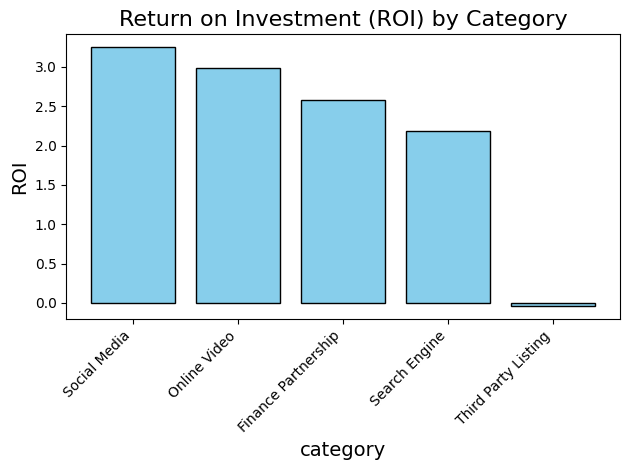

In [ ]:
# Roi figure

plt.figure()
plt.bar(roi['category'], roi['roi'], color='skyblue', edgecolor='black')
plt.title('Fig: 1Return on Investment (ROI) by Category', fontsize=16)
plt.xlabel('category', fontsize=14)
plt.ylabel('ROI', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

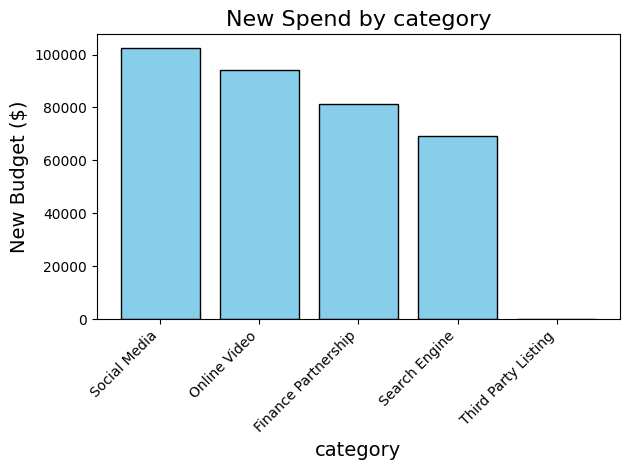

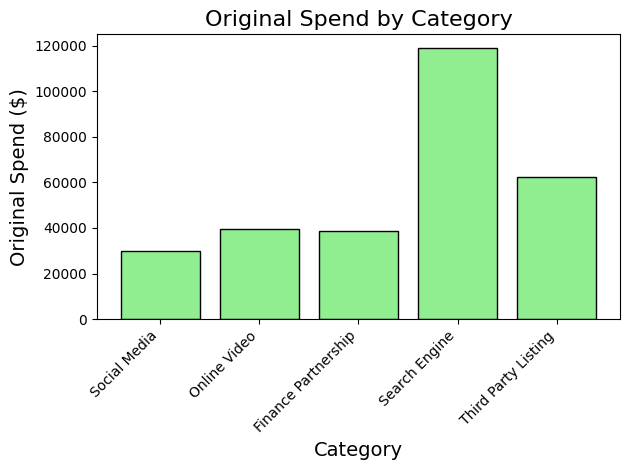

In [ ]:
# New Proposed Budget
plt.figure()
plt.bar(updated_df['category'], updated_df['New_Budget'], color='skyblue', edgecolor='black')
plt.title('New Spend by category', fontsize=16)
plt.xlabel('category', fontsize=14)
plt.ylabel('New Budget ($)', fontsize=14)
plt.xticks(rotation=45, ha='right') # ha: horizontal alignment to the right of the tick
plt.tight_layout()
plt.show()

# Original Spend
plt.figure()
plt.bar(updated_df['category'], updated_df['spend'], color='lightgreen', edgecolor='black')
plt.title('Original Spend by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Original Spend ($)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()